In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Proje için gerekli olan kütüphaneleri import ettikten sonra CSV formatındaki dosyamızı okutuyoruz. Ardından veriseti ile ilgili biraz bilgi edinmek için verisetini inceliyoruz.

In [4]:
df = pd.read_csv("titanic_train_set.csv")

In [9]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age sütununda 177 adet, Cabin sütununda 687 adet, Embarked sütununda ise 2 adet boş veri var. Cabin sütunundaki verilerde çok büyük bir oranda kayıp olduğu için o sütunu doldurmaya çalışmak yerine tablomdan silme yöntemini deneyeceğim. Age sütunundaki boş verileri ise ortalama verilerle, Embarked sütununu ise en çok tekrar eden verilerle yani verisetinin mod değeri ile dolduracağım.

In [11]:
df = df.drop("Cabin",axis=1)

Yaş ortalaması: 29.69911764705882


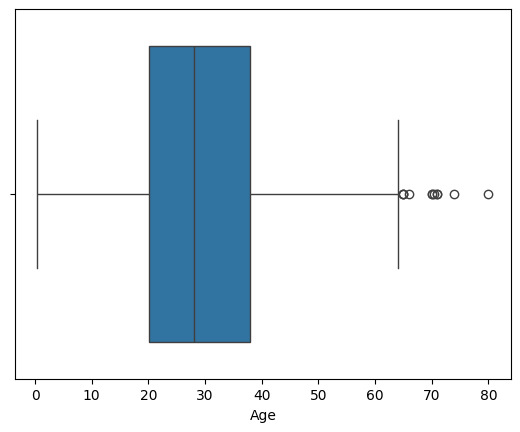

In [20]:
sns.boxplot(x=df["Age"])
print("Yaş ortalaması:",df["Age"].mean())

<Axes: xlabel='Age', ylabel='Count'>

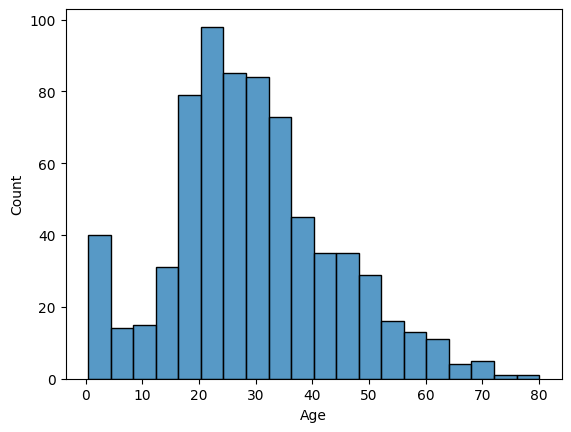

In [23]:
sns.histplot(data=df["Age"])

In [29]:
df["Age"] = df["Age"].fillna(df["Age"].mean())

In [30]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [17]:
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

Modelimizde hangi sütunların kullanılacağına karar verip gereksiz olduğunu düşündüğümüz sütunları tablodan çıkaracağım

In [23]:
df = df.drop(["Name","Ticket"],axis=1)

In [27]:
df = df.drop(["PassengerId"],axis=1)

In [28]:
df.drop(["Sex","Embarked"],axis=1).corr()["Survived"]

Survived    1.000000
Pclass     -0.338481
Age        -0.069809
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

Korelasyon değerine bakarak hedef feature olarak belirlediğimiz Survived değerini hangi sütunların ne oranda etkilediğine bakacağız. Ardından gerekli feature engineering işlemlerini yaparak veriyi daha hazır hale getireceğiz. Mesela ben bu verisetinde SibSp (kardeş sayısı) ve Parch (ebeveyn sayısı) sütunlarını birleştirerek FamilySize adında (toplam aile birey sayısı) ikisini tek bir sütun olarak kullanacağım.

In [30]:
df["FamilySize"] = df["Parch"] + df["SibSp"]
df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,1
2,1,3,female,26.0,0,0,7.9250,S,0
3,1,1,female,35.0,1,0,53.1000,S,1
4,0,3,male,35.0,0,0,8.0500,S,0


In [31]:
df = df.drop(["SibSp","Parch"],axis=1)
df

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,male,22.000000,7.2500,S,1
1,1,1,female,38.000000,71.2833,C,1
2,1,3,female,26.000000,7.9250,S,0
3,1,1,female,35.000000,53.1000,S,1
4,0,3,male,35.000000,8.0500,S,0
...,...,...,...,...,...,...,...
886,0,2,male,27.000000,13.0000,S,0
887,1,1,female,19.000000,30.0000,S,0
888,0,3,female,29.699118,23.4500,S,3
889,1,1,male,26.000000,30.0000,C,0


Sex ve Embarked sütunlarını string değer olarak modelimizde kullanamayacağımız için sayısal değere çevirmemiz gerekiyor.

In [32]:
df = pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.000000,7.2500,1,True,False,True
1,1,1,38.000000,71.2833,1,False,False,False
2,1,3,26.000000,7.9250,0,False,False,True
3,1,1,35.000000,53.1000,1,False,False,True
4,0,3,35.000000,8.0500,0,True,False,True
...,...,...,...,...,...,...,...,...
886,0,2,27.000000,13.0000,0,True,False,True
887,1,1,19.000000,30.0000,0,False,False,True
888,0,3,29.699118,23.4500,3,False,False,True
889,1,1,26.000000,30.0000,0,True,False,False


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   Fare        891 non-null    float64
 4   FamilySize  891 non-null    int64  
 5   Sex_male    891 non-null    bool   
 6   Embarked_Q  891 non-null    bool   
 7   Embarked_S  891 non-null    bool   
dtypes: bool(3), float64(2), int64(3)
memory usage: 37.5 KB


Bu aşamadan sonrası ise modelimizin train ve test verilerini ayırmak ardından ise modelimizi eğitmek olacak.

In [36]:
X = df.drop("Survived",axis=1)
y = df["Survived"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [38]:
model = LogisticRegression(max_iter=200)
model.fit(X_train,y_train)

LogisticRegression(max_iter=200)

In [39]:
model.score(X_test,y_test)

0.8044692737430168

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8044692737430168
Confusion Matrix:
 [[90 15]
 [20 54]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       105
           1       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179



Son olarak ise logistic regression modelimizin performansını değerlendirmek için bazı önemli metrikleri kullanıyoruz. Modelin doğruluk oranı, Confusion matrix gibi şeyler bize oluşturduğumuz modelin test seti üzerinde ne derecede başarılı sonuçlar verdiğini göstermektedir.